# EMA Analyses

Kendra Wyant

In [ ]:
#|echo: FALSE

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")

ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

In [ ]:
#| echo: FALSE
#| output: False

path_processed <- format_path("studydata/risk/data_processed/ema")
path_models <- format_path("studydata/risk/models/ema")
path_shared <- format_path("studydata/risk/data_processed/shared")

auc_week <- read_rds(file.path(path_models, "outer_metrics_1week_0_v5_nested_main.rds")) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_day <- read_rds(file.path(path_models, "outer_metrics_1day_0_v5_nested_main.rds")) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_hour <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v5_nested_main.rds")) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)


auc <- auc_week |> 
  rename(week = roc_auc) |> 
  mutate(day = auc_day$roc_auc,
         hour = auc_hour$roc_auc) 

auc_week_baseline <- read_rds(file.path(path_models, "outer_metrics_1week_0_v3_nested_baseline.rds")) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_day_baseline <- read_rds(file.path(path_models, "outer_metrics_1day_0_v3_nested_baseline.rds")) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_hour_baseline <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v3_nested_baseline.rds")) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_baseline <- auc_week_baseline |> 
  rename(week_baseline = roc_auc) |> 
  mutate(day_baseline = auc_day_baseline$roc_auc,
         hour_baseline = auc_hour_baseline$roc_auc) |> 
  full_join(auc, by = c("repeat_num", "fold_num"))

In [ ]:
#| echo: false
#| output: false

set.seed(101)
pp <- auc |> 
  rename(id = repeat_num,
         id2 = fold_num) |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id),
           transform = tidyposterior::logit_trans,  
           iter = 2000, chains = 4,  
           adapt_delta = .99,
           family = gaussian) 


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.351 seconds (Warm-up)
Chain 1:                1.076 seconds (Sampling)
Chain 1:                2.42

### Posteriors

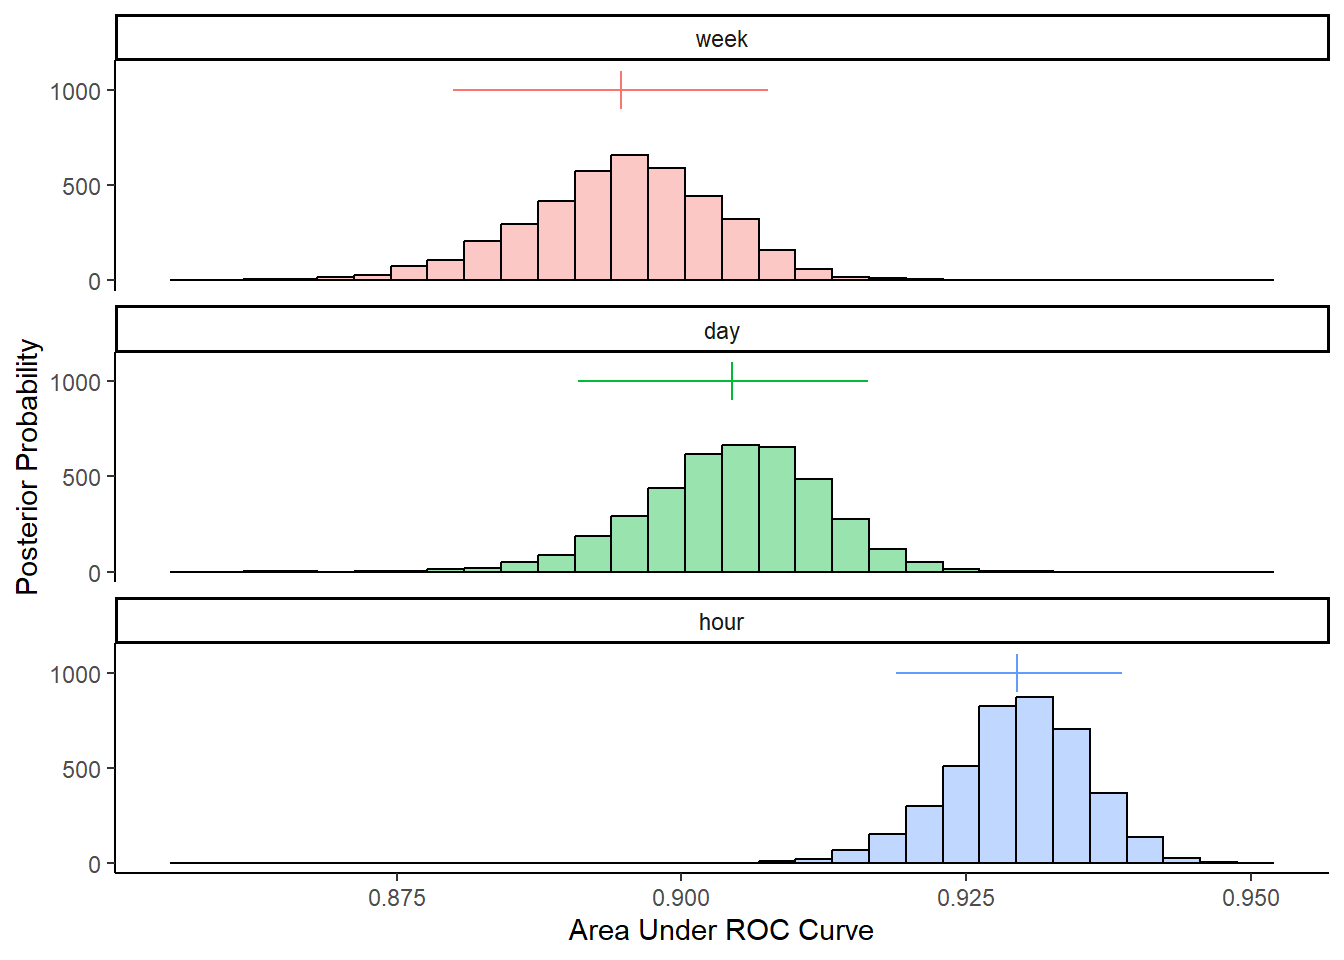

In [ ]:
#| label: fig-ema-posteriors
#| fig-cap: "Caption"

pp_tidy |> 
  mutate(model = factor(model, levels = c("week", "day", "hour"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                           color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, color = model),
                data = ci) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve")  +
  theme(legend.position = "none")
  # geom_text(aes(c("Median = 0.90", "Median = 0.91", "Median = .93")))

### Model Contrasts

In [ ]:
#| echo: false

ci <- pp |> 
  contrast_models(list("hour","hour", "day"), 
                list("week", "day", "week")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("hour vs week", "hour vs day", "day vs week"),
                           labels = c("Hour vs. Week", "Hour vs. Day", "Day vs. Week")),
         y = 850)

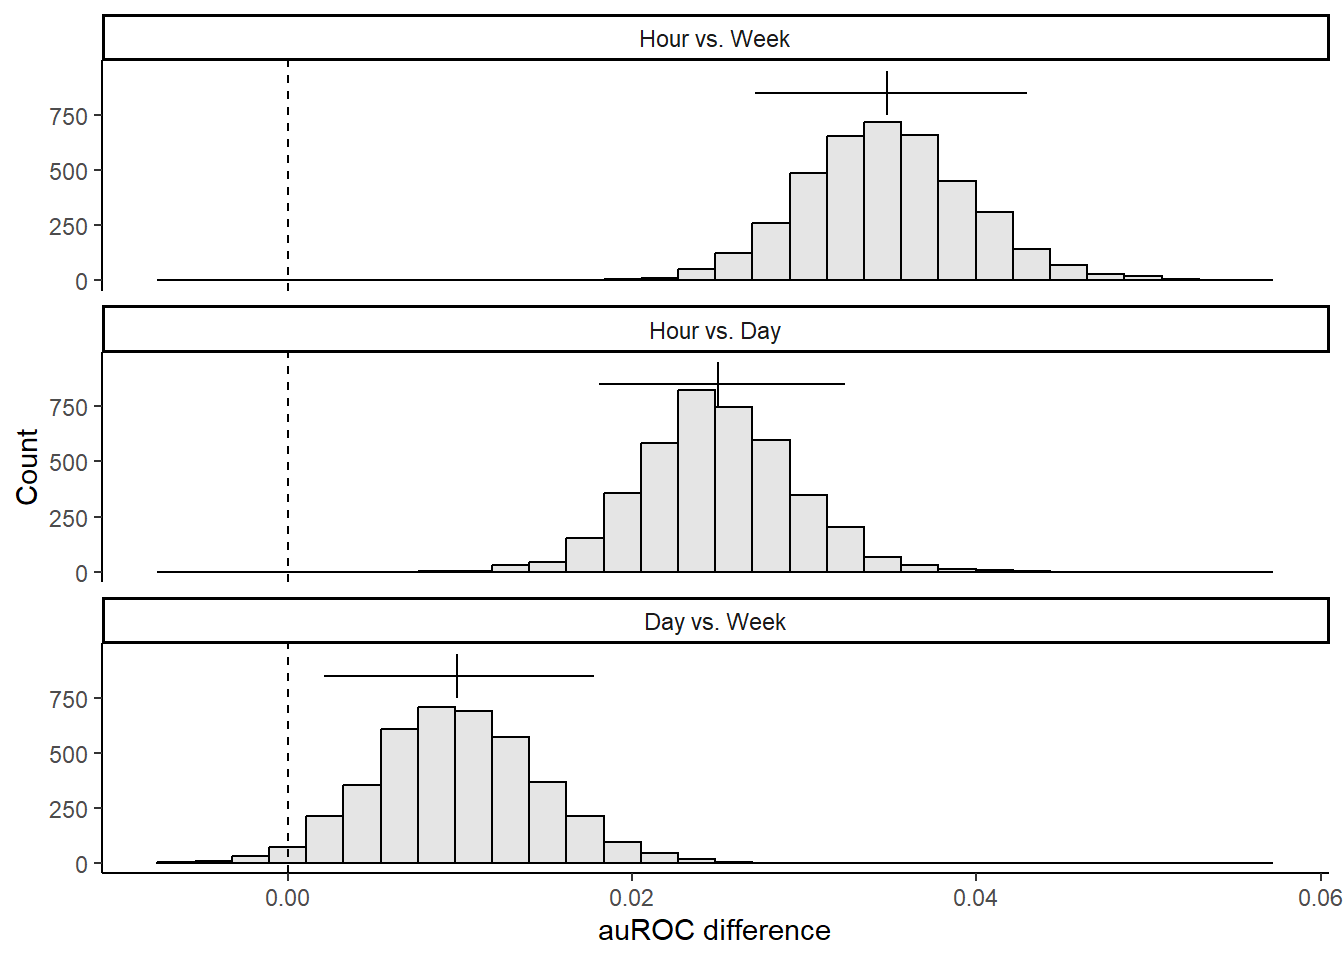

In [ ]:
#| label: fig-ema-contrasts
#| fig-cap: "Caption"

pp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(hour_vs_week = hour - week,
         hour_vs_day = hour - day,
         day_vs_week = day - week) |> 
  pivot_longer(cols = hour_vs_week:day_vs_week,
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast, 
                           levels = c("hour_vs_week", "hour_vs_day", "day_vs_week"),
                           labels = c("Hour vs. Week", "Hour vs. Day", "Day vs. Week"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior), 
                 color = "black", fill = "grey", alpha = .4, bins = 30) +
  geom_vline(xintercept = 0, color = "black", linetype = "dashed") +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean), 
               data = ci, show.legend = FALSE) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), 
               data = ci, show.legend = FALSE) +
  # geom_text(data = ci, x = c(.0255, .043, .018), y = 700, 
  #           label = str_c(round(ci$mean, 2), " [", round(ci$lower, 2), ", ", round(ci$upper, 2), "]")) +
  facet_wrap(~contrast, ncol = 1) +
  xlab("auROC difference") +
  ylab("Count") +
  theme(legend.position = "none")

### Baseline Model Comparisons

In [ ]:
#| echo: false
#| output: false

set.seed(101)
pp_baseline <- auc_baseline |> 
  rename(id = repeat_num,
         id2 = fold_num) |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id),
           transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
           iter = 2000, chains = 4,  
           adapt_delta = .99,
           family = gaussian) 


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.177 seconds (Warm-up)
Chain 1:                1.431 seconds (Sampling)
Chain 1:                4.60

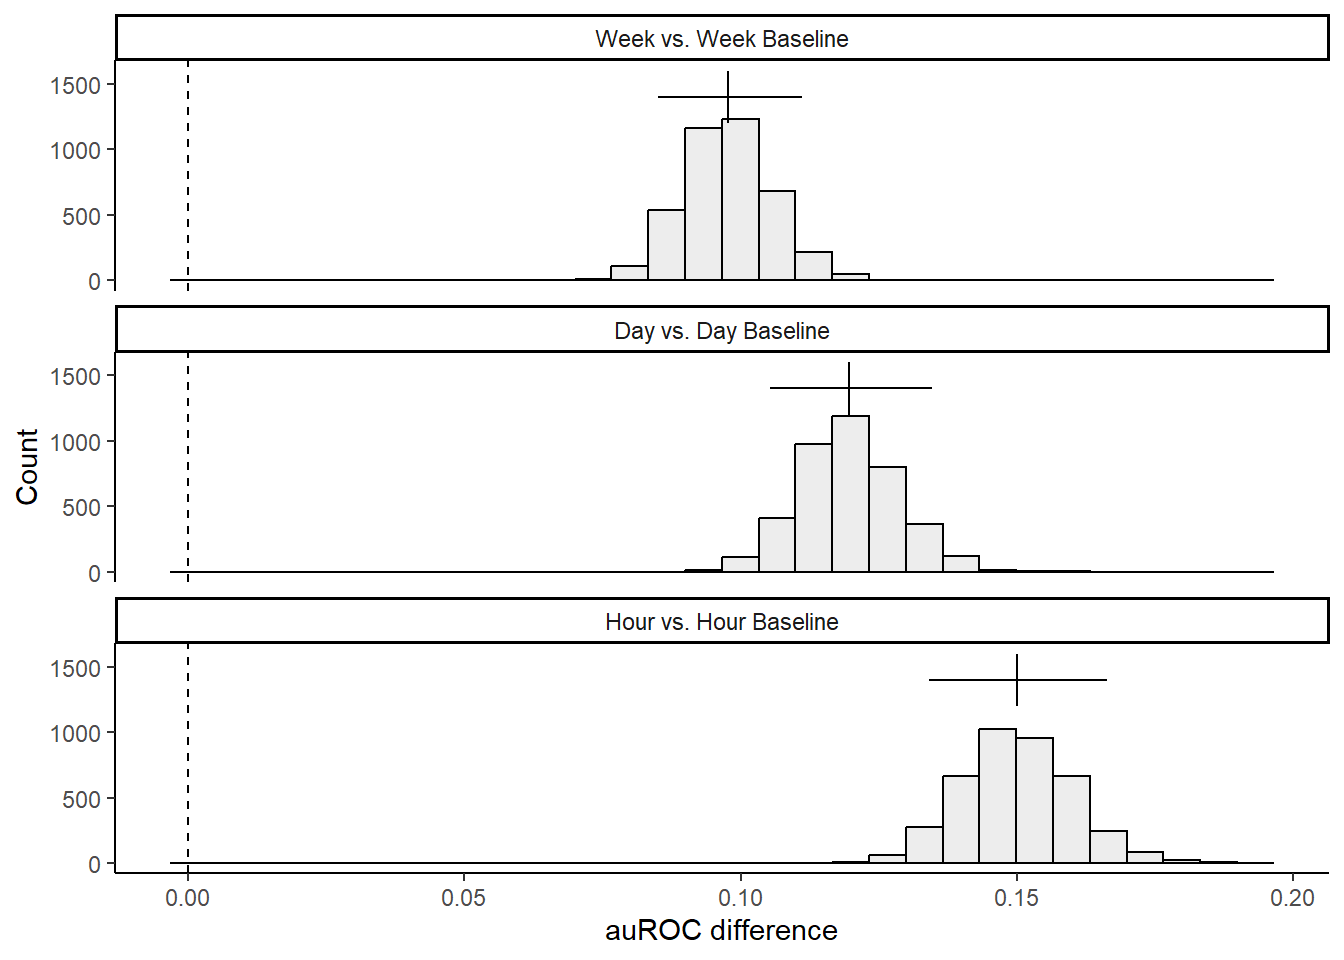

In [ ]:
#| label: fig-ema-baseline
#| fig-cap: "Caption"

pp_baseline |>
  tidy(seed = 123) |>
  group_by(model) |>
  mutate(sample = row_number()) |>
  ungroup() |>
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(hour_vs_hour_baseline = hour - hour_baseline,
         day_vs_day_baseline = day - day_baseline,
         week_vs_week_baseline = week - week_baseline) |>
  pivot_longer(cols = hour_vs_hour_baseline:week_vs_week_baseline,
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast,
                           levels = c("week_vs_week_baseline",
                                      "day_vs_day_baseline",
                                      "hour_vs_hour_baseline"),
                           labels = c("Week vs. Week Baseline",
                                      "Day vs. Day Baseline",
                                      "Hour vs. Hour Baseline"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior), 
                 color = "black", fill = "light grey", 
                 alpha = .4, bins = 30, show.legend = FALSE) +
  geom_vline(xintercept = 0, color = "black", linetype = "dashed") +
  geom_segment(mapping = aes(y = y+600, yend = y+200, x = mean, xend = mean),
               data = ci_baseline, show.legend = FALSE) +
  geom_segment(mapping = aes(y = y+400, yend = y+400, x = lower, xend = upper), 
               data = ci_baseline, show.legend = FALSE) +
  facet_wrap(~contrast, ncol = 1) +
  xlab("auROC difference") +
  ylab("Count") +
  theme(legend.position = "none")